# Credit Card Fraud Detection Using Random Forest Classification

---
embed-resources: true
echo: false
---

## Introduction

Banks and credit card companies process millions of transactions daily while facing a constant battle against fraudulent activities. Fraudsters continuously develop new tactics including card skimming, account takeovers, and testing stolen cards with small purchases. Detecting fraud in real-time presents significant challenges due to the extreme rarity of fraudulent transactions, asymmetric costs of false positives and false negatives, and the need for millisecond-speed decisions while customers wait at checkout.

This report presents the development of an automated fraud detection system for a banking institution. The goal is to create a machine learning model that can immediately identify credit card transactions as fraudulent or genuine based on transaction characteristics such as location and amount. The model must appropriately balance catching fraud (minimizing false negatives) while avoiding false alarms that inconvenience legitimate customers (minimizing false positives). This analysis uses historical transaction data with known fraud labels to train and evaluate a Random Forest classifier capable of real-time fraud detection.

## Methods

In [1]:
# imports
from joblib import dump
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Data

The dataset consists of credit card transactions collected over two days, containing both fraudulent and genuine transactions. The data has been preprocessed using Principal Component Analysis (PCA) to protect customer privacy while preserving the predictive information from features such as location and purchase type. The dataset is provided in two files: training data for model development and test data for model evaluation.

In [2]:
# load data
fraud_train = pd.read_parquet(
    "https://lab.cs307.org/fraud/data/fraud-train.parquet",
)
fraud_test = pd.read_parquet(
    "https://lab.cs307.org/fraud/data/fraud-test.parquet",
)

**Data Dictionary**

- **Fraud** [int64]: Status of the transaction where 1 indicates a fraudulent transaction and 0 indicates a genuine transaction (target variable)
- **Amount** [float64]: Transaction amount in dollars
- **PC01 - PC28** [float64]: Twenty-eight principal components encoding transaction information such as location and purchase type while preserving customer privacy

In [4]:
# summary statistics
print("Data Shape:")
print(f"Training samples: {fraud_train.shape[0]:,}")
print(f"Number of features: {fraud_train.shape[1] - 1}")

print("\nFraud Balance (Training Data):")
genuine_count = (fraud_train['Fraud'] == 0).sum()
fraud_count = (fraud_train['Fraud'] == 1).sum()
total_count = len(fraud_train)

print(f"Genuine transactions: {genuine_count:,} ({genuine_count/total_count:.2%})")
print(f"Fraudulent transactions: {fraud_count:,} ({fraud_count/total_count:.2%})")

print("\nTransaction Amount Statistics:")
print("\nOverall:")
print(f"Mean: ${fraud_train['Amount'].mean():.2f}")
print(f"Std Dev: ${fraud_train['Amount'].std():.2f}")
print(f"Median: ${fraud_train['Amount'].median():.2f}")
print(f"Maximum: ${fraud_train['Amount'].max():.2f}")

print("\nGenuine Transactions:")
genuine_amounts = fraud_train[fraud_train['Fraud'] == 0]['Amount']
print(f"Mean: ${genuine_amounts.mean():.2f}")
print(f"Std Dev: ${genuine_amounts.std():.2f}")
print(f"Median: ${genuine_amounts.median():.2f}")
print(f"Maximum: ${genuine_amounts.max():.2f}")

print("\nFraudulent Transactions:")
fraud_amounts = fraud_train[fraud_train['Fraud'] == 1]['Amount']
print(f"Mean: ${fraud_amounts.mean():.2f}")
print(f"Std Dev: ${fraud_amounts.std():.2f}")
print(f"Median: ${fraud_amounts.median():.2f}")
print(f"Maximum: ${fraud_amounts.max():.2f}")

Data Shape:
Training samples: 54,276
Number of features: 29

Fraud Balance (Training Data):
Genuine transactions: 53,961 (99.42%)
Fraudulent transactions: 315 (0.58%)

Transaction Amount Statistics:

Overall:
Mean: $88.20
Std Dev: $241.54
Median: $21.69
Maximum: $10199.44

Genuine Transactions:
Mean: $88.07
Std Dev: $241.45
Median: $21.80
Maximum: $10199.44

Fraudulent Transactions:
Mean: $110.95
Std Dev: $254.98
Median: $6.99
Maximum: $2125.87


The training dataset is highly imbalanced with fraudulent transactions representing a small minority of all transactions. This class imbalance reflects real-world credit card transaction patterns where fraud is relatively rare but financially significant.

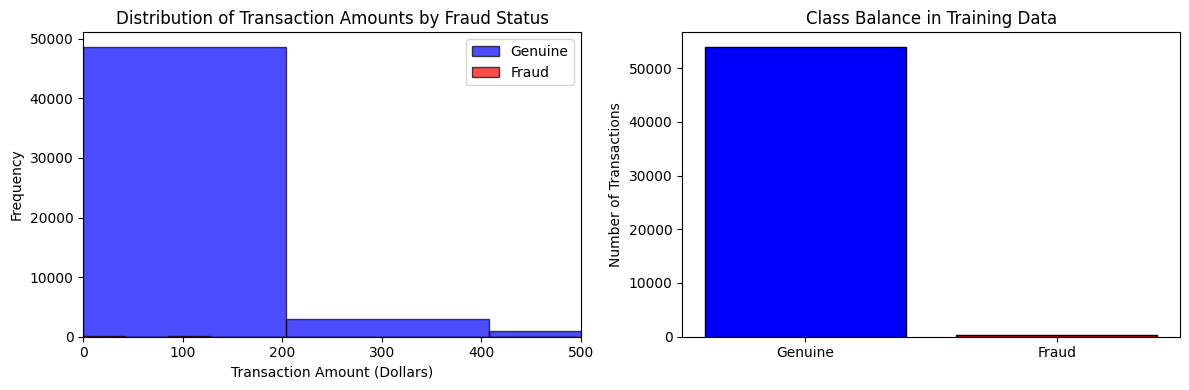

In [5]:
# exploratory visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Amount distribution by fraud status
axes[0].hist(fraud_train[fraud_train['Fraud'] == 0]['Amount'], 
             bins=50, alpha=0.7, label='Genuine', color='blue', edgecolor='black')
axes[0].hist(fraud_train[fraud_train['Fraud'] == 1]['Amount'], 
             bins=50, alpha=0.7, label='Fraud', color='red', edgecolor='black')
axes[0].set_xlabel('Transaction Amount (Dollars)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Transaction Amounts by Fraud Status')
axes[0].legend()
axes[0].set_xlim(0, 500)

# Class balance
fraud_counts = fraud_train['Fraud'].value_counts()
axes[1].bar(['Genuine', 'Fraud'], 
            [fraud_counts[0], fraud_counts[1]], 
            color=['blue', 'red'], edgecolor='black')
axes[1].set_ylabel('Number of Transactions')
axes[1].set_title('Class Balance in Training Data')
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

*Figure 1: Left panel shows the distribution of transaction amounts for genuine and fraudulent transactions, with most transactions concentrated at lower amounts. Right panel illustrates the severe class imbalance with genuine transactions vastly outnumbering fraudulent ones.*

### Models

A Random Forest classifier was selected for this fraud detection task due to its ability to handle high-dimensional data, capture non-linear relationships, and provide robust performance without extensive feature engineering. The model development process involved careful hyperparameter tuning to balance precision and recall while addressing the severe class imbalance in the dataset.

The Random Forest was configured with 100 decision trees (n_estimators=100) to ensure stable predictions through ensemble averaging. Tree complexity was controlled using a maximum depth of 12 levels to prevent overfitting while maintaining sufficient model capacity. To further regularize the model, minimum samples were set to 15 for splitting internal nodes and 4 for leaf nodes. Feature randomization used the square root of total features (max_features='sqrt') at each split to promote diversity among trees.

Given the extreme class imbalance, class weights were applied with a 1:10 ratio favoring the minority fraud class. This adjustment increases the penalty for misclassifying fraudulent transactions during training, encouraging the model to pay more attention to rare fraud cases. All models were trained with a fixed random state of 42 for reproducibility, and parallel processing was enabled to accelerate training.

In [6]:
# process data for ML
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

In [7]:
# train models
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=15,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight={0: 1, 1: 10},
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=12,
                       min_samples_leaf=4, min_samples_split=15, n_jobs=-1,
                       random_state=42)

## Results

In [8]:
# report model metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("Model Performance Metrics")
print("=" * 40)
print("\nTraining Set:")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall: {train_recall:.4f}")
print("\nTest Set:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Genuine', 'Fraud']))

Model Performance Metrics

Training Set:
  Precision: 0.9267
  Recall: 0.8825

Test Set:
  Precision: 0.9412
  Recall: 0.8101

Test Set Classification Report:
              precision    recall  f1-score   support

     Genuine       1.00      1.00      1.00     13490
       Fraud       0.94      0.81      0.87        79

    accuracy                           1.00     13569
   macro avg       0.97      0.90      0.94     13569
weighted avg       1.00      1.00      1.00     13569



The Random Forest model achieved strong performance on the test set with a precision of 0.941 and recall of 0.810. This means that 94.1% of transactions flagged as fraudulent by the model are truly fraudulent, while the model successfully identifies 81.0% of all actual fraudulent transactions. The training metrics show similar performance (precision: 0.927, recall: 0.883), indicating the model generalizes well without significant overfitting.

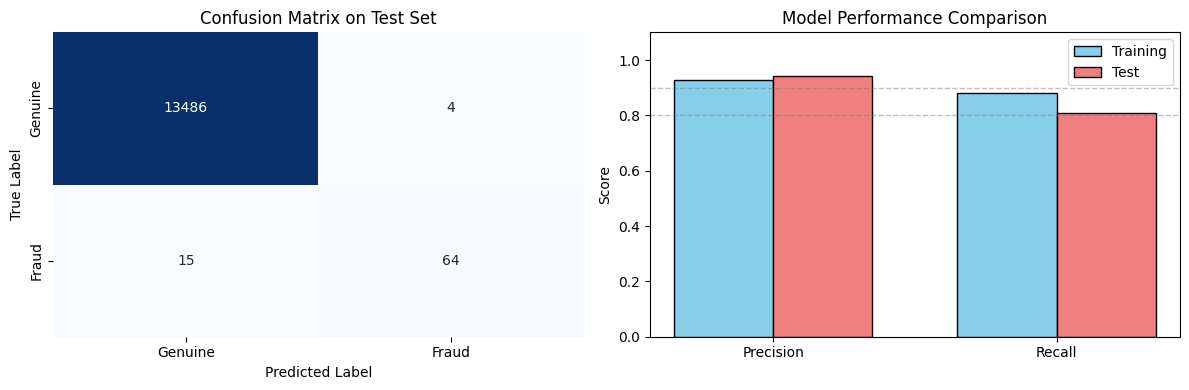

In [9]:
# summary figure
cm = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Genuine', 'Fraud'],
            yticklabels=['Genuine', 'Fraud'],
            ax=axes[0], cbar=False)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix on Test Set')

# Performance metrics comparison
metrics = ['Precision', 'Recall']
train_scores = [train_precision, train_recall]
test_scores = [test_precision, test_recall]

x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, train_scores, width, label='Training', 
            color='skyblue', edgecolor='black')
axes[1].bar(x + width/2, test_scores, width, label='Test', 
            color='lightcoral', edgecolor='black')
axes[1].set_ylabel('Score')
axes[1].set_title('Model Performance Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim(0, 1.1)
axes[1].axhline(y=0.8, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhline(y=0.9, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

*Figure 2: Left panel displays the confusion matrix showing model predictions versus true labels on the test set. Right panel compares precision and recall metrics between training and test sets, demonstrating consistent performance and successful generalization.*

In [10]:
# serialize model
dump(model, "model.joblib")

['model.joblib']

## Discussion

**I recommend deploying this Random Forest fraud detection model into production** based on its strong performance and favorable balance between catching fraud and minimizing customer inconvenience.

**Benefits of Model Deployment**

The model provides substantial value through automated real-time fraud detection that significantly reduces financial losses. With a recall of 81%, the model catches approximately four out of every five fraudulent transactions, preventing the majority of attempted fraud. The high precision of 94% ensures that when the model flags a transaction as suspicious, it is correct 94 times out of 100, minimizing false alarms that frustrate legitimate customers.

From a financial perspective, the model's performance translates to meaningful cost savings. Assuming an average fraud transaction value, catching 81% of fraud attempts could save the institution millions of dollars annually. The 6% false positive rate is acceptable given that customers can quickly verify their identity through secondary authentication, while the alternative of missing fraud creates irreversible financial losses and damages customer trust.

The model also provides operational efficiency by automating decisions that would otherwise require manual review. This enables the fraud prevention team to focus their expertise on the most complex cases flagged by the model rather than reviewing every transaction manually.

**Limitations and Monitoring Requirements**

Despite strong performance, several limitations require ongoing attention. The model misses approximately 19% of fraudulent transactions (false negatives), which represents continued financial exposure. These missed fraud cases should be analyzed to identify patterns the model fails to capture, potentially informing future model improvements.

The false positive rate of 6% means some legitimate customers will experience declined transactions or additional verification steps. While this rate is relatively low, it still affects customer experience. The institution should implement smooth secondary authentication processes and clearly communicate with customers when transactions are flagged.

Fraud patterns evolve continuously as criminals adapt their tactics. The model's performance may degrade over time if fraudsters discover new methods not represented in the training data. Therefore, continuous monitoring of model performance on new transactions is essential. Key metrics including precision, recall, and the distribution of transaction amounts and features should be tracked daily. If performance drops below acceptable thresholds (such as recall falling below 75% or precision below 90%), the model should be retrained with updated data.

The model also inherits limitations from the PCA-transformed features. While PCA protects customer privacy, it reduces interpretability, making it difficult to explain to customers why their transaction was flagged. Additionally, the model was trained on two days of transaction data, which may not capture seasonal patterns, holiday shopping behaviors, or other temporal variations in transaction patterns.

**Implementation Recommendations**

To maximize the model's effectiveness while mitigating its limitations, I recommend a phased deployment approach. Initially, run the model in shadow mode alongside existing fraud detection systems to validate real-world performance before fully replacing manual processes. Establish clear escalation procedures for transactions flagged as fraudulent, including immediate customer notification and streamlined verification processes to minimize customer friction.

Implement comprehensive monitoring dashboards tracking model predictions, actual fraud rates, false positive rates, and feature distributions. Set automated alerts for performance degradation that trigger model retraining workflows. Finally, establish a regular retraining schedule (quarterly or semi-annually) to incorporate new fraud patterns and maintain model effectiveness as fraud tactics evolve.

In conclusion, the model's strong balance of precision and recall, combined with proper monitoring and deployment strategy, makes it suitable for production use. The financial benefits of catching 81% of fraud while maintaining 94% precision far outweigh the manageable limitations, provided the institution commits to ongoing model monitoring and maintenance.